# Projet 4 - Construisez un modèle de scoring

# Installation & Imports des bibliothèques

In [ ]:
# !pip install uv
# !uv venv venv_projet_4.1 --python 3.11.6


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Using CPython 3.11.6
Creating virtual environment at: venv_projet_4.1
Activate with: venv_projet_4.1\Scripts\activate


In [ ]:
# # Installation des librairies
# !uv pip install pandas matplotlib seaborn
# !uv pip install missingno
# !uv pip install skimpy missingno
# !uv pip install scikit-learn
# !uv pip install pycaret

In [67]:
# Import des librairies
import pandas as pd # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt # type: ignore
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

%matplotlib inline

# Contexte & Objectifs

Le projet consiste à développer un modèle de scoring de crédit pour une société de crédit à la consommation. L'objectif est de prédire la probabilité de défaut de remboursement d'un emprunteur en se basant sur des informations comme son historique de crédit, ses revenus, etc. Le modèle doit être interprétable, ce qui signifie qu'on doit pouvoir comprendre et expliquer les décisions prises par le modèle. Le problème principal du projet est donc de construire un modèle précis, robuste et interprétable pour évaluer le risque de crédit.

Les données fournie sont plusieurs fichier csv qui s'ordonne de la manière suivante:

![Architecture des données](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Il existe 7 sources de données différentes :

- **application_train/application_test** : données principales d'entrainement et de test contenant des informations sur chaque demande de prêt. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données d'entraînement contiennent la variable `TARGET` indiquant si le prêt a été remboursé (0) ou non (1).

- **bureau** : données concernant les crédits antérieurs des clients auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans `bureau`, mais un prêt dans les données d'application peut avoir plusieurs crédits antérieurs.

- **bureau_balance** : données mensuelles concernant les crédits antérieurs présents dans `bureau`. Chaque ligne représente un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

- **previous_application** : données sur les demandes de prêt précédentes faites auprès de Home Credit par des clients ayant des prêts dans les données d'application. Chaque prêt actuel peut avoir plusieurs prêts antérieurs. Chaque demande de prêt antérieure a une ligne unique et est identifiée par la caractéristique `SK_ID_PREV`.

- **POS_CASH_BALANCE** : données mensuelles sur les prêts en point de vente ou en espèces précédemment accordés par Home Credit. Chaque ligne représente un mois d'un prêt en point de vente ou en espèces antérieur, et un prêt unique peut avoir de nombreuses lignes.

- **credit_card_balance** : données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne est un mois de solde d'une carte de crédit, et une carte de crédit unique peut avoir de nombreuses lignes.

- **installments_payment** : historique des paiements pour les prêts antérieurs chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.


De plus, nous disposons des définitions de toutes les colonnes (dans le fichier `HomeCredit_columns_description.csv`) ainsi qu’un exemple de fichier de soumission attendu.


Nous allons d'abord utiliser les données principales d'entraînement et de test par soucis de simplicité, ce qui nous permettra d’aborder  dans un premier temps le problème plus simplement avant de peut-etre intégrer les autres sources de données.

# Exploratory Data Analysis (EDA)

![EDA Schema](https://media.geeksforgeeks.org/wp-content/uploads/20240509161456/Steps-for-Performing-Exploratory-Data-Analysis.png)

## Information Generales

### Lecture du dataframe

In [68]:
df_origin = pd.read_csv('../data/application_train.csv')
df = df_origin.copy()

X_train = df.drop('TARGET', axis=1)
Y_train = df.TARGET

### Informations generales

In [69]:
print(f'Shape du dataframe: {df.shape}\n')
df.info()

Shape du dataframe: (307511, 122)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### Dtypes

In [70]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

### Describe

In [71]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


## Valeurs manquantes

### Valeurs manquantes par colonnes

In [72]:
# Calcul des valeurs manquantes par columns
df.isnull().sum().sort_values(ascending=False)

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
                             ...  
NAME_HOUSING_TYPE                0
NAME_FAMILY_STATUS               0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
SK_ID_CURR                       0
Length: 122, dtype: int64

In [73]:
# Calcul des valeurs manquantes par columns en %
missing_percent_cols = (df.isna().sum() / len(df)) * 100
missing_percent_cols = missing_percent_cols.sort_values(ascending=False)
print(missing_percent_cols)

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
                              ...    
NAME_HOUSING_TYPE            0.000000
NAME_FAMILY_STATUS           0.000000
NAME_EDUCATION_TYPE          0.000000
NAME_INCOME_TYPE             0.000000
SK_ID_CURR                   0.000000
Length: 122, dtype: float64


In [74]:
# nombre de colonnes avec plus de 50% de valeurs manquantes
superior_50_cols = missing_percent_cols[missing_percent_cols > 50]  # noqa: F821
print(f'Colonnes avec plus de 50% de valeurs manquantes: {len(superior_50_cols)}')

Colonnes avec plus de 50% de valeurs manquantes: 41


### Heatmap des valeurs manquantes

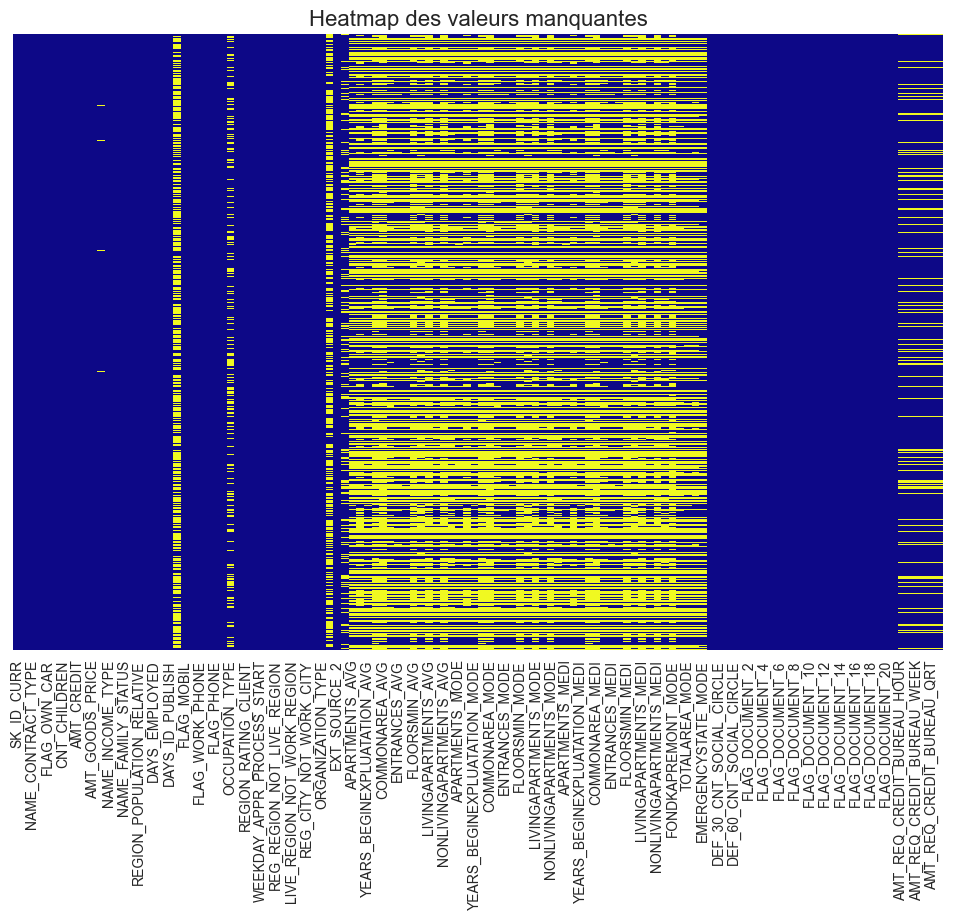

In [75]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cmap='plasma', cbar=False, yticklabels=False)
plt.title('Heatmap des valeurs manquantes', fontsize=16)
plt.show()

In [76]:
# Clacul du pourcentage general manquant dans le dataframe
total_missing_percent = (df.isna().sum().sum() / df.size) * 100
print(f"Pourcentage de valeurs manquantes dans le DataFrame : {total_missing_percent:.2f}%")


Pourcentage de valeurs manquantes dans le DataFrame : 24.40%


### Suppression des colonnes > 40% de missing values

In [77]:
drop_cols = missing_percent_cols[missing_percent_cols > 40]
df = df.drop(list(drop_cols.index), axis=1)

<Axes: >

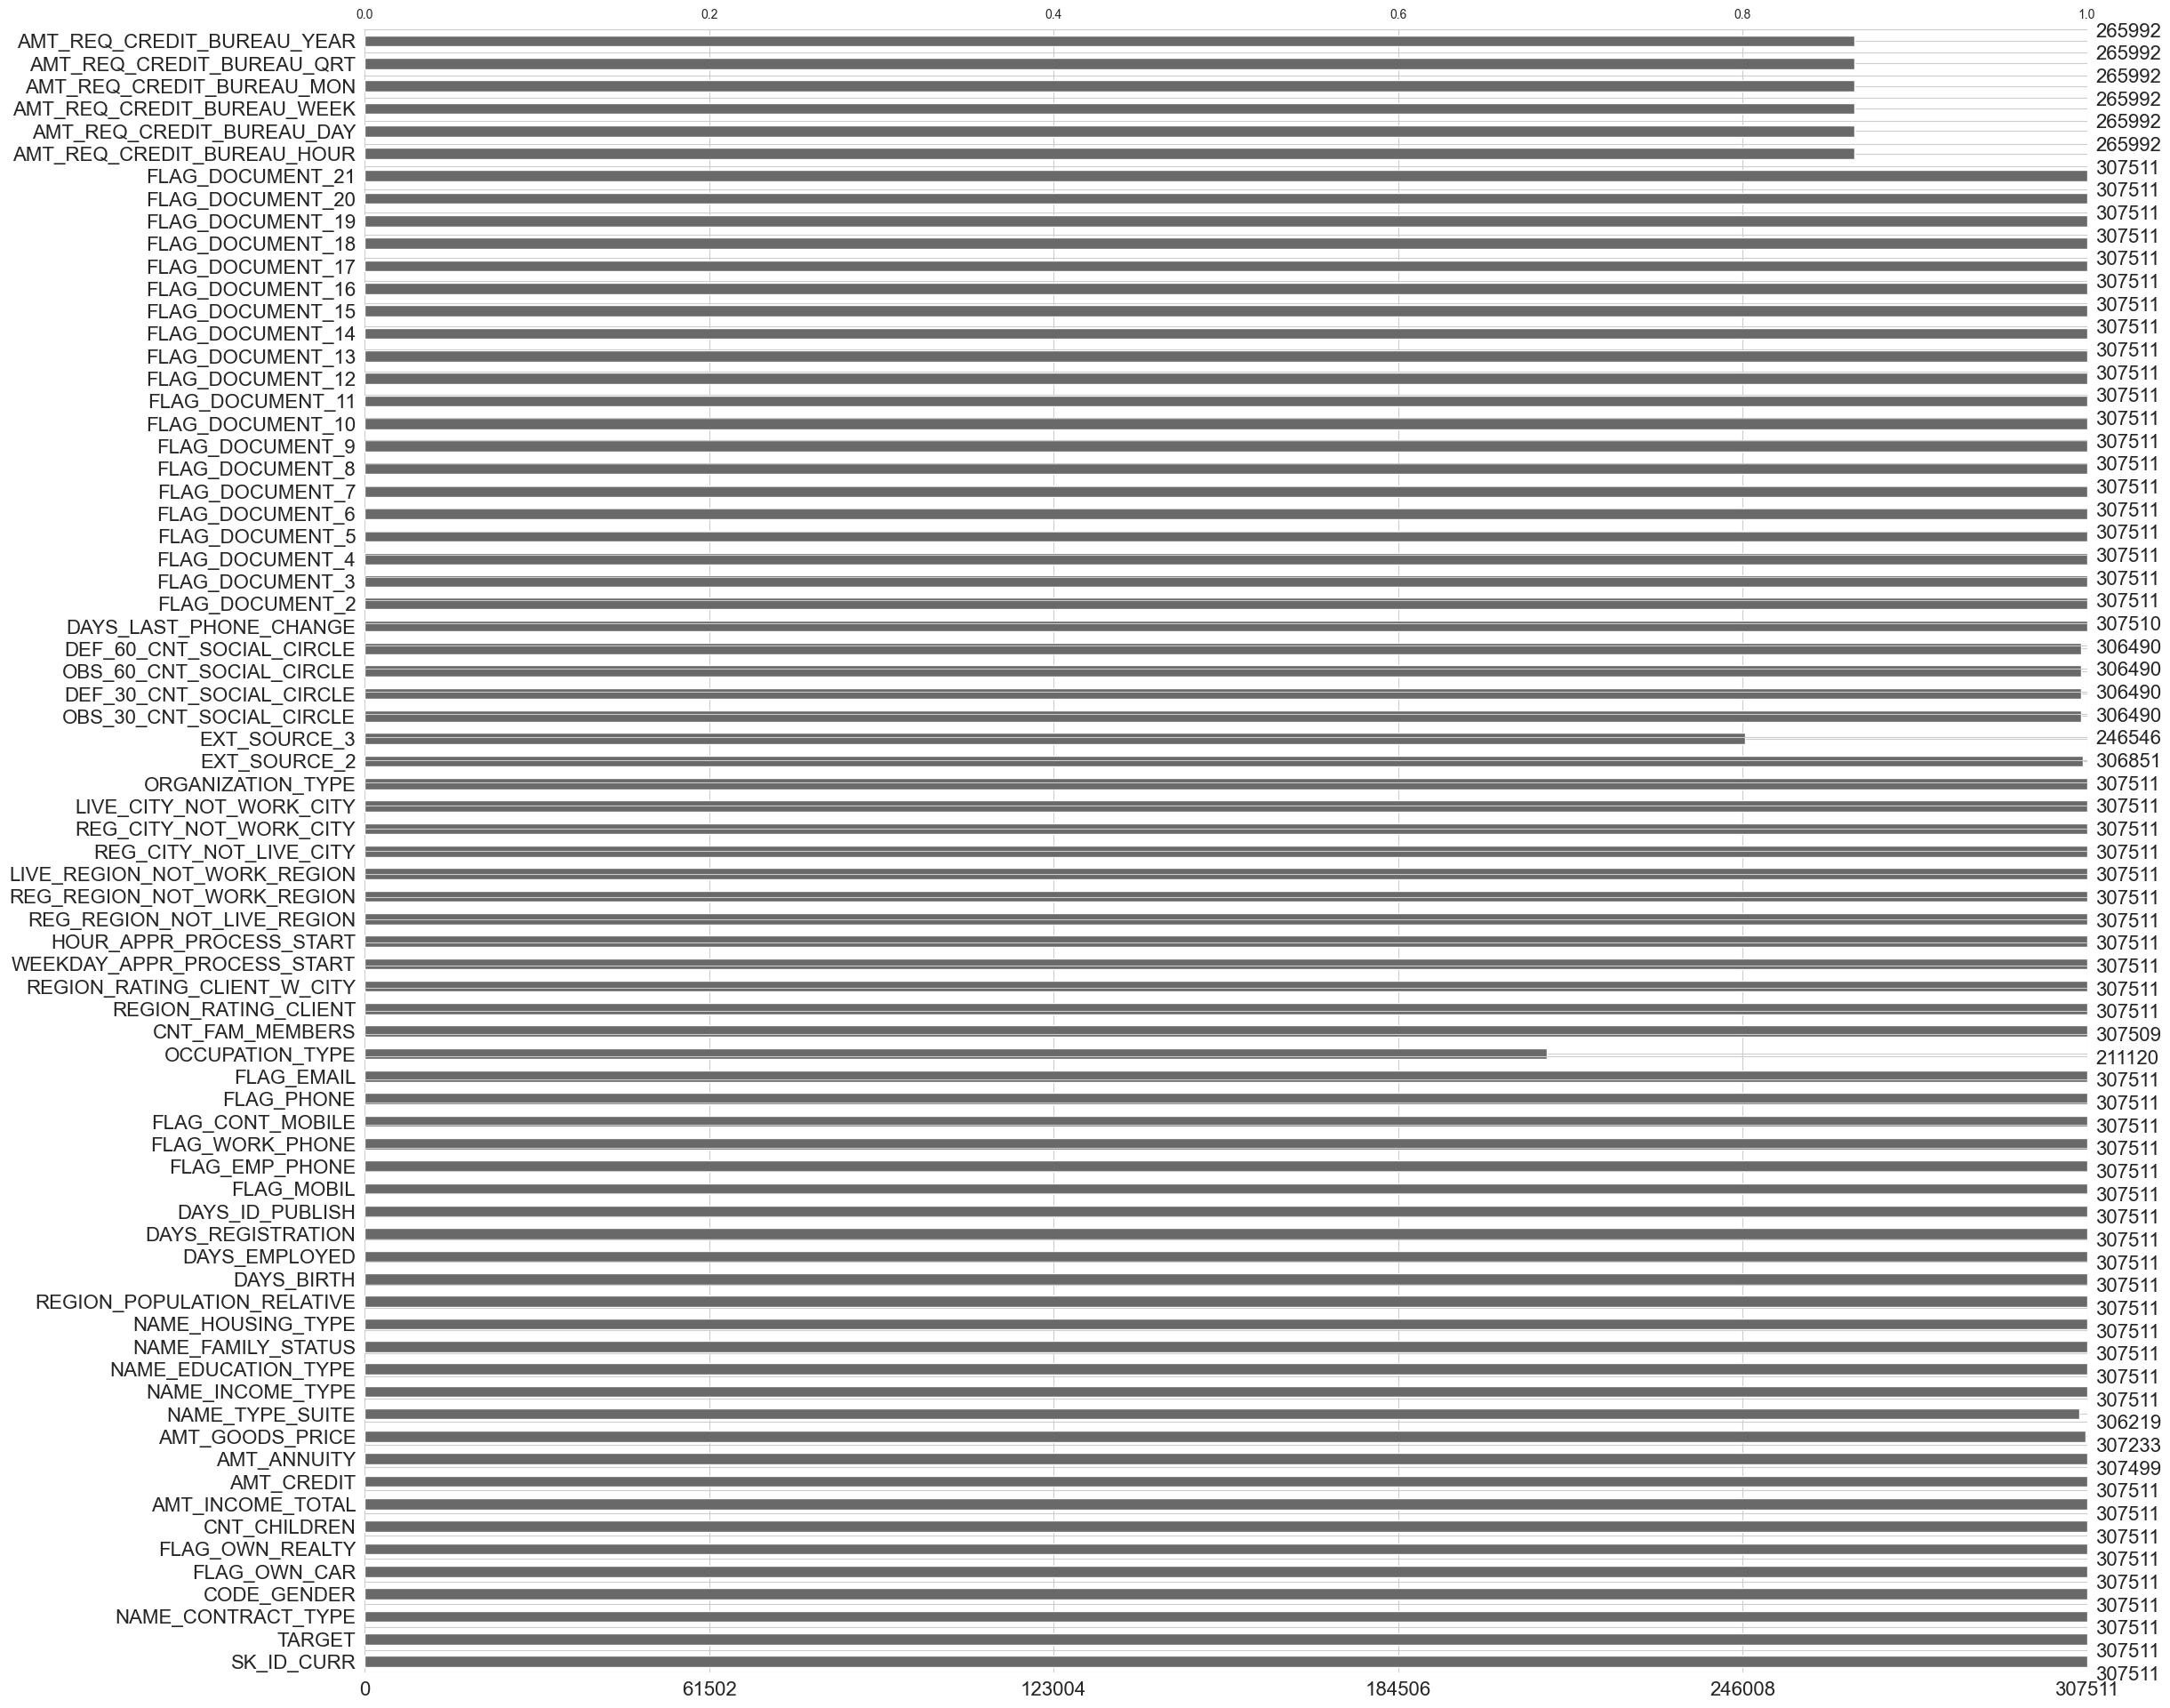

In [78]:
# barchart des valeurs manquantes (après traitement)
msno.bar(df)

In [79]:
# Clacul du pourcentage general manquant dans le dataframe
total_missing_percent = (df.isna().sum().sum() / df.size) * 100
print(f"Pourcentage de valeurs manquantes dans le DataFrame : {total_missing_percent:.2f}%")


Pourcentage de valeurs manquantes dans le DataFrame : 1.84%


### Colonnes sans contexte projet

Voici les colonnes identifiées comme potentiellement inutiles, car elles ce sont des identifiants ou des informations personnelles qui ne contribuent pas directement à la prédiction de la probabilité de remboursement :

- SK_ID_CURR : Identifiant unique du client.
- NAME_CONTRACT_TYPE : Type de contrat, souvent fixe et non discriminant dans la prédiction.
- NAME_TYPE_SUITE : Type de personne accompagnante (non pertinent pour le scoring crédit).
- NAME_INCOME_TYPE : Source de revenu, souvent redondante avec d'autres variables de revenu.
- NAME_EDUCATION_TYPE : Niveau d'éducation, peu pertinent dans certains contextes financiers.
- NAME_FAMILY_STATUS : Statut familial, souvent non corrélé directement au remboursement.
- NAME_HOUSING_TYPE : Type de logement, peu informatif pour un modèle financier.
- DAYS_ID_PUBLISH : Date de publication du document, non pertinent pour la prédiction.
- FLAG_EMP_PHONE : Indique si le téléphone professionnel est fourni, faible valeur prédictive.
- FLAG_WORK_PHONE : Même remarque que ci-dessus.
- FLAG_PHONE : Indique si un numéro de téléphone est fourni, souvent inutile.
- FLAG_EMAIL : Indique si une adresse email est fournie, non pertinent.
- DAYS_LAST_PHONE_CHANGE : Dernier changement de téléphone, faible lien avec la probabilité de remboursement.

In [80]:
useless_cols = [
    'SK_ID_CURR',
    'NAME_CONTRACT_TYPE',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'DAYS_ID_PUBLISH',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'DAYS_LAST_PHONE_CHANGE',
    'WEEKDAY_APPR_PROCESS_START'
]

df = df.drop(useless_cols, axis=1)

## Etude de la colonne Target

### Distribution de la colonne

In [81]:
# Display percentage of each value
print(Y_train.value_counts(), Y_train.value_counts(normalize=True))

TARGET
0    282686
1     24825
Name: count, dtype: int64 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


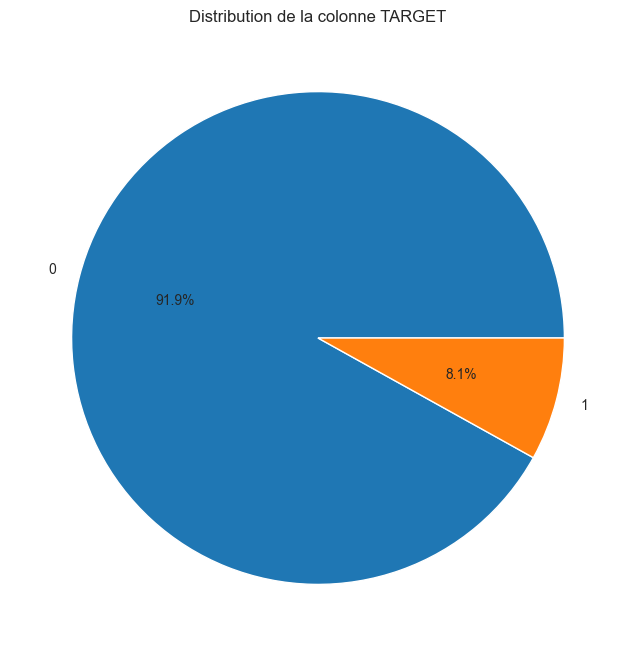

In [82]:
pie_chart_values = Y_train.value_counts()
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
plt.pie(pie_chart_values, labels=pie_chart_values.index, autopct='%1.1f%%')
plt.title('Distribution de la colonne TARGET')
plt.show()


On peut voir ici que notre TARGET est très hétérogène, c'est-à-dire que sur deux classe présente ici 0 et 1 il y a la classe 0 qui est présente a plus de 90 %, ce qui n'est pas le plus optimal pour pouvoir entraîner notre modèle par la suite, il faudra donc équilibrer les classes avant de pouvoir entraîner le modèle sous peine de le fausser.

## Correlations

### Barplot des correlations avec la colonne TARGET

C:\Users\vuill\AppData\Local\Temp\ipykernel_12544\3297607740.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


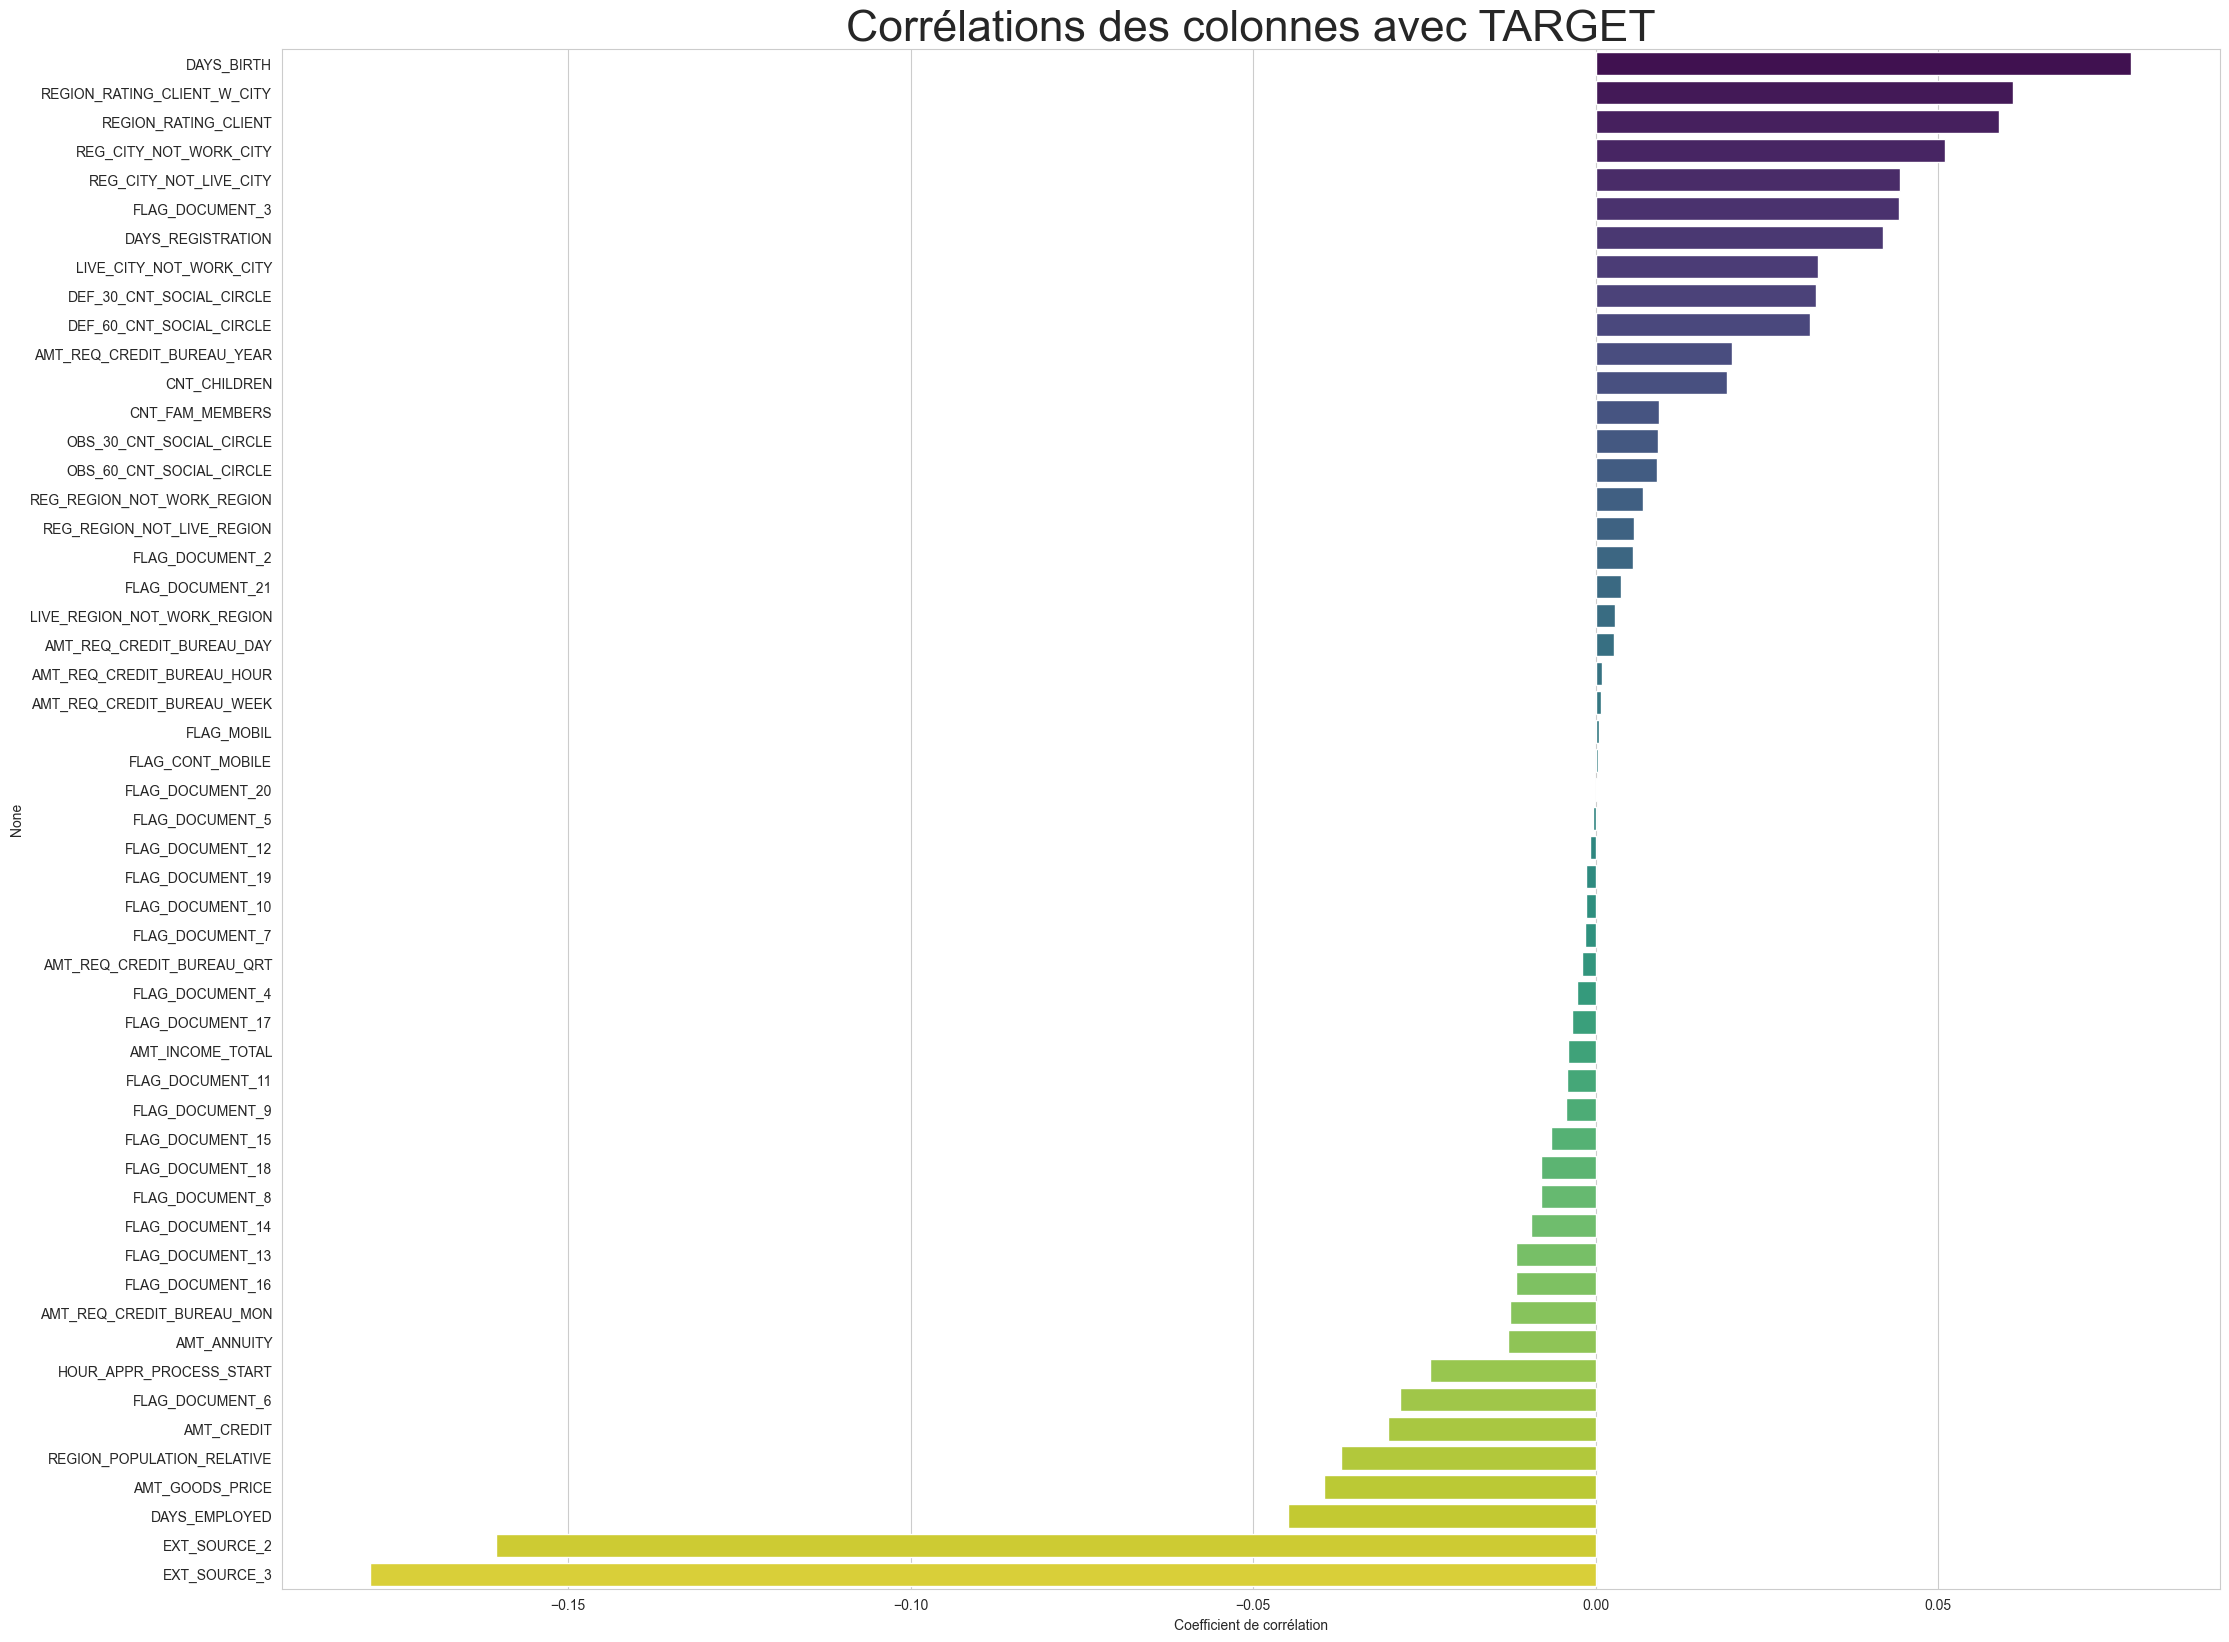

In [83]:
target_column = 'TARGET'
numerical_columns = list(df.select_dtypes(include="number").columns)
# Calculer les corrélations entre chaque colonne numérique et la cible
correlations = df[numerical_columns].corr()[target_column].drop(target_column)

# Trier les corrélations par ordre décroissant
correlations = correlations.sort_values(ascending=False)

# Afficher les corrélations avec un graphique en barres
plt.figure(figsize=(25, 20))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.title(f'Corrélations des colonnes avec {target_column}', fontsize=32)
plt.xlabel('Coefficient de corrélation')
plt.show()


### Matrice de corr

<Axes: >

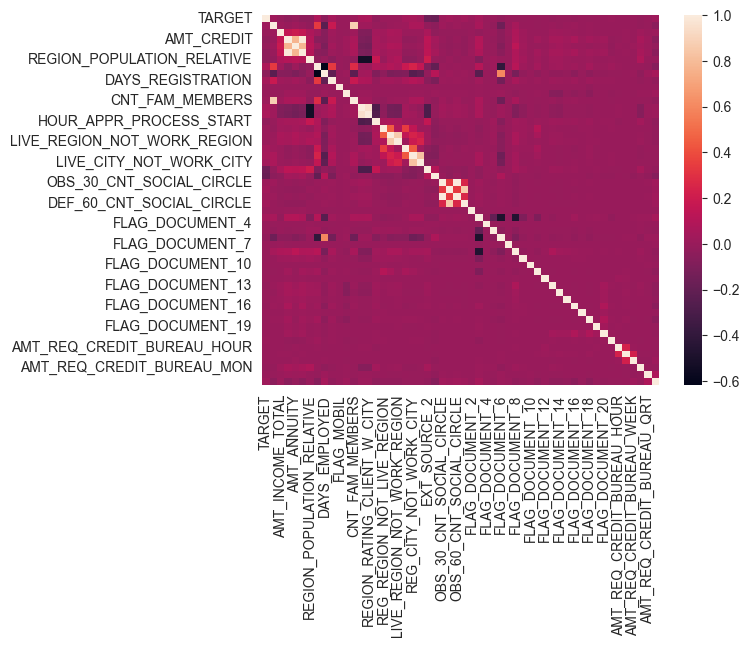

In [84]:
# Liste des colonnes numériques
numerical_columns = list(df.select_dtypes(include="number").columns)
target_column = 'target'  # Remplace 'target' par le nom exact de ta colonne cible

# Étape 1 : Supprimer les colonnes avec une variance nulle (colonnes constantes)
df_filtered = df[numerical_columns].loc[:, df[numerical_columns].std() > 0]

# Étape 2 : Calculer la matrice de corrélation et remplacer les NaN par 0
correlation_matrix = df_filtered.corr().fillna(0)

sns.heatmap(correlation_matrix)

In [85]:
df.dtypes.value_counts()

int64      35
float64    19
object      5
Name: count, dtype: int64

## Données Qualitatives

### Type de colonnes

In [86]:
# Afficher les colonnes cat
qualitative_columns = list(df.select_dtypes(include='object').columns)
print(qualitative_columns)

df[qualitative_columns].head(10)

['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,M,N,Y,Laborers,Business Entity Type 3
1,F,N,N,Core staff,School
2,M,Y,Y,Laborers,Government
3,F,N,Y,Laborers,Business Entity Type 3
4,M,N,Y,Core staff,Religion
5,M,N,Y,Laborers,Other
6,F,Y,Y,Accountants,Business Entity Type 3
7,M,Y,Y,Managers,Other
8,F,N,Y,NaN,XNA
9,M,N,Y,Laborers,Electricity


#### Features binaires

In [87]:
# Colonne dite a valeurs binaire 
binary_features = [
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY'
]

# Verification des valeurs pour chaques colonnes
for col in df[binary_features]:
    print(col, df[col].unique())

CODE_GENDER ['M' 'F' 'XNA']
FLAG_OWN_CAR ['N' 'Y']
FLAG_OWN_REALTY ['Y' 'N']


In [88]:
# Regarder si XNA est une variable a prendre en compte ou non
df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [89]:
# Suppression des lignes du df contenant XNA
df['CODE_GENDER'] = df['CODE_GENDER'].where(df['CODE_GENDER'] != 'XNA')
df['CODE_GENDER'].value_counts()

CODE_GENDER
F    202448
M    105059
Name: count, dtype: int64

In [90]:
# Application de get_dummies sur mes cols
for col in binary_features:
    df[col] = pd.get_dummies(df[col], drop_first=True).astype(int)

df[binary_features]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,1,0,1
1,0,0,0
2,1,1,1
3,0,0,1
4,1,0,1
...,...,...,...
307506,1,0,0
307507,0,0,1
307508,0,0,1
307509,0,0,1


Pour mes colonnes sur lesquelles on ne peut pas appliquer un get dummies on va dans un premier temps regarder leur caractéristique et ensuite trouver la methode adequate

In [91]:
# Recuperation du nombres de valeurs diff
df['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [92]:
# Recuperation du nombres de valeurs diff
df['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

### Features categorielles

Dans le cas de nos variables categorielle nous aurions pu utiliser one hot encoder mais cela risque d'augmenter la charge computationel et la pertinence de mes colonnes pour ce faire j'utilise la frequency encoding qui consiste à remplacer la valeur categorielle par sa frequence d'appartion dans le dataset

Tous les options envisagé: 
- One Hot Encoder
- Frequence Encoding
- Target Encoding
- Embedding
- Ordinal Encoding

La methode retenue est le Target Encoding car il permet un remplaement rapide tout en gardant la complexité entre la target et la colonnes target comme l'explicite ce [paper universitaire](https://arxiv.org/pdf/2104.00629)

In [93]:
# Calcul de la moyenne de la cible pour chaque catégorie
target_mean_organisation_type = df.groupby('ORGANIZATION_TYPE')['TARGET'].mean()

df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].map(target_mean_organisation_type)

# Affichage du résultat
print("Train DataFrame with Target Encoding:")
df['ORGANIZATION_TYPE'].head()

Train DataFrame with Target Encoding:


0    0.092996
1    0.059148
2    0.069781
3    0.092996
4    0.058824
Name: ORGANIZATION_TYPE, dtype: float64

In [94]:
# Calcul de la moyenne de la cible pour chaque catégorie
target_mean_organisation_type = df.groupby('OCCUPATION_TYPE')['TARGET'].mean()

df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].map(target_mean_organisation_type)

# Affichage du résultat
print("Train DataFrame with Target Encoding:")
df['OCCUPATION_TYPE'].head()

Train DataFrame with Target Encoding:


0    0.105788
1    0.063040
2    0.105788
3    0.105788
4    0.063040
Name: OCCUPATION_TYPE, dtype: float64

## Creation de nouvelles variables

In [95]:
binary_columns = [
    col for col in df.columns 
    if set(df[col].dropna().unique()).issubset({0, 1}) or set(df[col].dropna().unique()).issubset({'Y', 'N'})
]

print(binary_columns)

['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


### Colonne FLAG

In [96]:
# Afficher le type de toutes le colonnes FLAG
print(df.filter(like='FLAG').dtypes)


# Recuperer toutes les colonnes qui sont un FLAG
flags_columns = df.filter(like='FLAG')

# Additionner numeriquement toutes les colonnes pour n'en faire plus qu'une
df['FLAGS'] = df.filter(like='FLAG').sum(axis=1)

# Afficher les information de la colonne crée
df.FLAGS.describe()

#  Supprimer toutes les colonnes flags
df = df.drop(flags_columns, axis=1)

FLAG_OWN_CAR        int32
FLAG_OWN_REALTY     int32
FLAG_MOBIL          int64
FLAG_CONT_MOBILE    int64
FLAG_DOCUMENT_2     int64
FLAG_DOCUMENT_3     int64
FLAG_DOCUMENT_4     int64
FLAG_DOCUMENT_5     int64
FLAG_DOCUMENT_6     int64
FLAG_DOCUMENT_7     int64
FLAG_DOCUMENT_8     int64
FLAG_DOCUMENT_9     int64
FLAG_DOCUMENT_10    int64
FLAG_DOCUMENT_11    int64
FLAG_DOCUMENT_12    int64
FLAG_DOCUMENT_13    int64
FLAG_DOCUMENT_14    int64
FLAG_DOCUMENT_15    int64
FLAG_DOCUMENT_16    int64
FLAG_DOCUMENT_17    int64
FLAG_DOCUMENT_18    int64
FLAG_DOCUMENT_19    int64
FLAG_DOCUMENT_20    int64
FLAG_DOCUMENT_21    int64
dtype: object


In [97]:
binary_columns = [
    col for col in df.columns 
    if set(df[col].dropna().unique()).issubset({0, 1}) or set(df[col].dropna().unique()).issubset({'Y', 'N'})
]

print(binary_columns)

['TARGET', 'CODE_GENDER', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']


### Colonne REGION_SCORE

In [98]:
# Afficher le type de toutes le colonnes FLAG
print(df.filter(like='REGION').dtypes)

#Afficher les informations generales des colonnes clé
df[df.filter(like='REGION').columns].describe()

REGION_POPULATION_RELATIVE     float64
REGION_RATING_CLIENT             int64
REGION_RATING_CLIENT_W_CITY      int64
REG_REGION_NOT_LIVE_REGION       int64
REG_REGION_NOT_WORK_REGION       int64
LIVE_REGION_NOT_WORK_REGION      int64
dtype: object


,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.020868,2.052463,2.031521,0.015144,0.050769,0.040659
std,0.013831,0.509034,0.502737,0.122126,0.219526,0.197499
min,0.000290,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.010006,2.000000,2.000000,0.000000,0.000000,0.000000
50%,0.018850,2.000000,2.000000,0.000000,0.000000,0.000000
75%,0.028663,2.000000,2.000000,0.000000,0.000000,0.000000
max,0.072508,3.000000,3.000000,1.000000,1.000000,1.000000


In [99]:
# Récupérer toutes les colonnes qui contiennent 'REGION' dans leur nom
region_columns = list(df.filter(like='REGION').columns)

# Ajouter les autres colonnes relatives au score région
region_columns += ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

# Afficher la liste finale des colonnes liées à la région
print(region_columns)

# Additionner numeriquement toutes les colonnes pour n'en faire plus qu'une
df['REGION_SCORE'] = df[region_columns].sum(axis=1)

# Afficher les information de la colonne crée
print(df.REGION_SCORE.describe())

#  Supprimer toutes les colonnes regs
df = df.drop(region_columns, axis=1)

['REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
count    307511.000000
mean          4.699605
std           1.435383
min           2.003541
25%           4.010966
50%           4.026392
75%           6.010276
max          12.020713
Name: REGION_SCORE, dtype: float64


### Colonne AMT

Voici les variables commençant par "AMT" dans le dataset :
- AMT_INCOME_TOTAL : Revenu total déclaré du client.
- AMT_CREDIT : Montant total du crédit demandé.
- AMT_ANNUITY : Montant de l'annuité prévue pour rembourser le crédit.
- AMT_GOODS_PRICE : Prix des biens financés par le crédit.
- AMT_REQ_CREDIT_BUREAU_HOUR : Nombre de demandes de crédit faites dans les dernières heures.
- AMT_REQ_CREDIT_BUREAU_DAY : Nombre de demandes de crédit faites dans la dernière journée.
- AMT_REQ_CREDIT_BUREAU_WEEK : Nombre de demandes de crédit faites dans la dernière semaine.
- AMT_REQ_CREDIT_BUREAU_MON : Nombre de demandes de crédit faites dans le dernier mois.
- AMT_REQ_CREDIT_BUREAU_QRT : Nombre de demandes de crédit faites dans le dernier trimestre.
- AMT_REQ_CREDIT_BUREAU_YEAR : Nombre de demandes de crédit faites dans la dernière année.



In [100]:
# Recuperer toutes les colonnes AMT
amt_columns = df.filter(like='AMT').columns

# Afficher les colonnes amt
print(amt_columns)

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')


#### Ratio
Ces ratios aident à capturer des relations relatives entre différentes mesures financières :

- Ratio revenu/crédit → Reflète la proportion de revenu par rapport au montant du crédit.
- Ratio annuité/crédit → Indique la charge relative de l'annuité par rapport au montant du crédit.
- Ratio crédit/prix des biens → Montre la proportion financée par le crédit par rapport au prix des biens.
- Ratio revenu/annuité → Évalue combien de fois le revenu peut couvrir l'annuité.

In [101]:
# Retio revenu global / credit 
df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

# Ratio Anuité credit
df['ANNUITY_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# Ratio crédit / prix des biens posseder
df['CREDIT_POSSESION_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

# Ratio Anuité / revenu
df['INCOME_ANNUITY_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']

#### PCA

In [102]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Verification des valeurs manquantes
print(df[amt_columns].isna().sum())
df = df.dropna()

# Normalisation des données
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(df[amt_columns])

# Application de la PCA
pca = PCA(n_components=1)
df['AMT_PCA'] = pca.fit_transform(amount_scaled)




AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      12
AMT_GOODS_PRICE                 278
AMT_REQ_CREDIT_BUREAU_HOUR    41519
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
dtype: int64


In [103]:
# Supression des colonnes AMT
df = df.drop(amt_columns, axis=1)

# Feature Selection

Maintenant que toutes mes colonnes sont des colonnes numerique je peux à présent utiliser des algorithmes de feature selection afin d'etre plus pertinent dans le choix de mes colonnes, et ainsi avoir de meilleur resultat pour mon futur modèle

In [104]:
# Suppression des lignes contenant des NAN
df = df.dropna()

# Define X, Y
X = df.drop('TARGET', axis=1)
Y = df.TARGET

#### SelectKBest (f_classif)

In [105]:
# Sélectionner les meilleures features
num_selector = SelectKBest(score_func=f_classif, k='all').fit(X, Y)

# Scores numériques
scores = num_selector.scores_

# Créer un dataframe pour seaborn
feature_scores = pd.DataFrame({
    'Feature': np.array(X.columns),
    'Score': scores
})

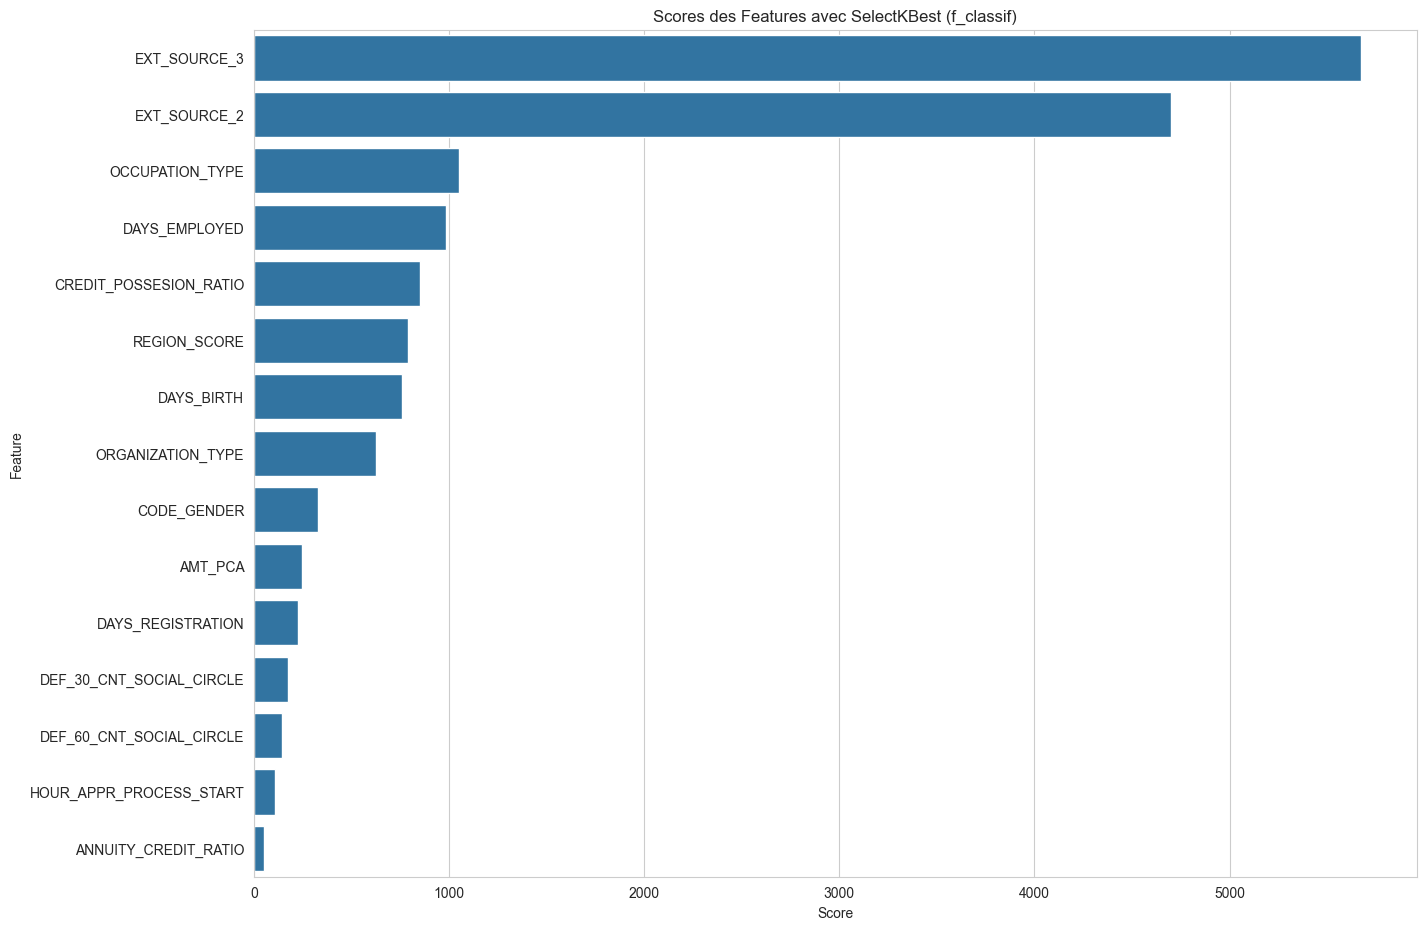

In [106]:
# Trier les scores par ordre décroissant
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Créer un graphique avec seaborn
plt.figure(figsize=(15, 11))
sns.barplot(x='Score', y='Feature', data=feature_scores[:15])
plt.title('Scores des Features avec SelectKBest (f_classif)')
plt.show()


# Entrainement du modèle

## Benchmark des modèle avec pycaret

In [107]:
df[feature_scores[:15]['Feature']]

,EXT_SOURCE_3,EXT_SOURCE_2,OCCUPATION_TYPE,DAYS_EMPLOYED,CREDIT_POSSESION_RATIO,REGION_SCORE,DAYS_BIRTH,ORGANIZATION_TYPE,CODE_GENDER,AMT_PCA,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,HOUR_APPR_PROCESS_START,ANNUITY_CREDIT_RATIO
0,0.139376,0.262949,0.105788,-637,1.158397,4.018801,-9461,0.092996,1,-0.748452,-3648.0,2.0,2.0,10,0.060749
2,0.729567,0.555912,0.105788,-225,1.000000,4.010032,-19046,0.069781,1,-2.180287,-4260.0,0.0,0.0,9,0.050000
5,0.621226,0.354225,0.105788,-1588,1.079198,4.035792,-16941,0.076425,1,-0.376160,-4970.0,0.0,0.0,16,0.056101
6,0.492060,0.724000,0.048303,-3130,1.118800,4.035792,-13778,0.092996,0,3.212303,-1213.0,0.0,0.0,16,0.026463
7,0.540654,0.714279,0.062140,-449,1.000000,8.003122,-18850,0.076425,1,3.448303,-4597.0,0.0,0.0,16,0.027500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.735221,0.313334,0.105788,-8736,1.000000,6.010966,-16063,0.059148,0,-1.775058,-8672.0,0.0,0.0,16,0.047200
307503,0.609276,0.501221,0.063040,-399,1.396000,4.022800,-11870,0.051855,0,-1.261564,-675.0,3.0,2.0,11,0.051433
307508,0.218859,0.535722,0.062140,-7921,1.158400,8.005002,-14966,0.059148,0,0.241711,-6737.0,0.0,0.0,9,0.044239
307509,0.661024,0.514163,0.105788,-4786,1.158394,6.005313,-11961,0.081384,0,-1.010033,-2562.0,0.0,0.0,9,0.054592


In [112]:
!pip install pycaret


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [114]:
import pycaret
from pycaret.classification import *


# Initialiser l'environnement PyCaret
clf1 = setup(data=df[feature_scores[:10]['Feature']], target=y, session_id=123, preprocess=False)

# Comparer les modèles en fonction de l'AUC
best_model = compare_models(sort='AUC')

# Afficher le modèle avec la meilleure AUC
print(f"Le meilleur modèle basé sur l'AUC est : {best_model}")


RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

In [110]:
# df[feature_importance[:15]['Feature']]

In [111]:
# import pycaret
# from pycaret.classification import *




# # Initialiser l'environnement PyCaret
# clf1 = setup(data=df[feature_importance[:15]['Feature']], target=Y, session_id=123, preprocess=False)

# # Comparer les modèles en fonction de l'AUC
# best_model = compare_models(sort='AUC')

# # Afficher le modèle avec la meilleure AUC
# print(f"Le meilleur modèle basé sur l'AUC est : {best_model}")
